In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
import glob

from tqdm import tqdm
import ray

In [2]:
full_data = pd.read_csv("./prepro_data/full_data.csv")
full_data = full_data.drop(full_data[full_data["loan_limit"].isnull()].index).reset_index().iloc[:, 1:] # FAQ 7번

In [3]:
submit_test = pd.read_csv("./prepro_data/submit_test.csv")
dataset = pd.concat([full_data, submit_test]).reset_index().iloc[:, 1:]

### 가성비변수

In [4]:
# loan_limit, loan_rate 비교우위 (같은 application 내 다른 상품들보다 비교적 조건이 좋으면 신청 가능성 높지 않을까 ?)

# get the max value of loan_limit and min value of loan_rate
max_loan_limit = dataset.groupby("application_id")["loan_limit"].max() + 1
min_loan_rate = dataset.groupby("application_id")["loan_rate"].min()

# divide loan_limit and loan_rate by the max value of loan_limit and loan_rate by looking at a lookup table of max_loan_limit and min_loan_rate
dataset["loan_limit/max_loan_limit"] = dataset["loan_limit"] / dataset["application_id"].map(max_loan_limit)
dataset["loan_rate/min_loan_rate"] = dataset["loan_rate"] / dataset["application_id"].map(min_loan_rate)

# drop the grouped columns
dataset

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,desired_amount,purpose,existing_loan_cnt,existing_loan_amt,num_not_approve,num_total_approve,num_approve,num_total_login,loan_limit/max_loan_limit,loan_rate/min_loan_rate
0,2157865,2022-05-09 08:44:59,54,235,20000000.0,16.5,1.0,346970,1970.0,1.0,...,10000000.0,생활비,12.0,162000000.0,5,7,2,13,1.000000,1.000000
1,576643,2022-05-09 10:54:53,54,235,11000000.0,16.5,0.0,545882,1977.0,1.0,...,20000000.0,생활비,7.0,106000000.0,5,7,2,13,1.000000,1.000000
2,576643,2022-05-09 10:54:53,11,118,3000000.0,20.0,0.0,545882,1977.0,1.0,...,20000000.0,생활비,7.0,106000000.0,5,7,2,13,0.272727,1.212121
3,2136706,2022-05-09 10:41:06,42,216,10000000.0,13.5,0.0,558819,1983.0,1.0,...,80000000.0,대환대출,2.0,58000000.0,5,7,2,13,0.208333,2.177419
4,2136706,2022-05-09 10:41:07,25,169,22000000.0,15.9,0.0,558819,1983.0,1.0,...,80000000.0,대환대출,2.0,58000000.0,0,2,2,8,0.458333,2.564516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13527223,1428218,2022-06-03 12:01:58,62,200,3000000.0,14.8,NaN,478802,1965.0,1.0,...,50000000.0,대환대출,2.0,56000000.0,0,1,1,0,0.066667,2.242424
13527224,1428218,2022-06-03 12:01:49,2,7,40000000.0,11.8,NaN,478802,1965.0,1.0,...,50000000.0,대환대출,2.0,56000000.0,0,1,1,0,0.888889,1.787879
13527225,1428218,2022-06-03 12:01:48,32,257,15000000.0,7.2,NaN,478802,1965.0,1.0,...,50000000.0,대환대출,2.0,56000000.0,0,1,1,0,0.333333,1.090909
13527226,1428218,2022-06-03 12:01:48,33,110,44000000.0,13.5,NaN,478802,1965.0,1.0,...,50000000.0,대환대출,2.0,56000000.0,0,1,1,0,0.977778,2.045455


In [5]:
existing_loan_amt = dataset.groupby("application_id")["existing_loan_amt"].max() + 1

In [6]:
dataset["desired_amount/existing_loan_amt"] = (dataset["desired_amount"]+1) / dataset["application_id"].map(existing_loan_amt)

In [7]:
dataset.loc[dataset[dataset["desired_amount/existing_loan_amt"].isnull()].index, "desired_amount/existing_loan_amt"] = 0.0

In [8]:
dataset["desired_amount/existing_loan_amt"].describe()

count    1.352723e+07
mean     1.908549e+07
std      1.393543e+08
min      9.380863e-10
25%      3.024194e-01
50%      9.444444e-01
75%      1.000000e+07
max      1.000000e+10
Name: desired_amount/existing_loan_amt, dtype: float64

## 추가 파생변수 (credit_score)

In [9]:
dataset = dataset.reset_index().iloc[:, 1:]

In [10]:
dataset["credit_score_nan"] = 0
dataset.loc[dataset[dataset["credit_score"].isnull()].index, "credit_score_nan"] = 1

### Credit score Encoding

In [11]:
dataset[dataset["credit_score_nan"] == 0]["is_applied"].value_counts() # 6 %

0.0    8518776
1.0     507402
Name: is_applied, dtype: int64

In [12]:
dataset[dataset["credit_score_nan"] == 1]["is_applied"].value_counts() # 4.4 %

0.0    1190899
1.0      52912
Name: is_applied, dtype: int64

In [13]:
def credit_enc(x):
    if x <= 60: return 0
    elif x < 100: return 1
    elif x < 140: return 2
    elif x < 180: return 3
    elif x < 220: return 4
    elif x < 260: return 5
    elif x < 300: return 6
    elif x < 340: return 7
    elif x < 380: return 8
    elif x < 420: return 9
    elif x < 460: return 10
    elif x < 500: return 11
    elif x < 540: return 12
    elif x < 580: return 13
    elif x < 620: return 14
    elif x < 660: return 15
    elif x < 700: return 16
    elif x < 740: return 17
    elif x < 780: return 18
    elif x < 820: return 19
    elif x < 860: return 20
    elif x < 900: return 21
    elif x < 940: return 22
    elif x < 980: return 23
    elif x <= 1000: return 24
    else: return 99


In [14]:
dataset["credit_score"].map(credit_enc).value_counts()

15    1515197
99    1509275
16    1482432
17    1319093
14    1114688
18    1082827
19     918617
23     915195
22     899755
21     834972
20     823618
13     483228
24     459551
12     127631
11      32647
10       3329
2        2046
9        1041
5         704
4         506
3         306
8         284
7         188
6          90
0           8
Name: credit_score, dtype: int64

In [15]:
dataset["credit_score"] = dataset["credit_score"].map(credit_enc)

### Gender, Birth_year

In [16]:
dataset.isna().sum()

application_id                            0
loanapply_insert_time                     0
bank_id                                   0
product_id                                0
loan_limit                                4
loan_rate                                 4
is_applied                          3257239
user_id                                   0
birth_year                           128095
gender                               128095
insert_time                               0
credit_score                              0
yearly_income                             6
income_type                               0
company_enter_month                       0
employment_type                           0
houseown_type                             0
desired_amount                            0
purpose                                   0
existing_loan_cnt                         0
existing_loan_amt                         0
num_not_approve                           0
num_total_approve               

In [17]:
dataset["gender_birth_nan"] = 0
dataset.loc[dataset[dataset["birth_year"].isnull()].index, "gender_birth_nan"] = 1

In [18]:
dataset["birth_year"] = (2022 - dataset["birth_year"])

In [19]:
def birth_enc(x):
    if x <= 25: return 0
    elif x < 30: return 1
    elif x < 35: return 2
    elif x < 40: return 3
    elif x < 45: return 4
    elif x < 50: return 5
    elif x < 55: return 6
    elif x < 60: return 7
    elif x < 65: return 8
    elif x < 70: return 9
    elif x < 80: return 10
    elif x < 90: return 11
    elif x < 100: return 12
    else: return 99


In [20]:
dataset["birth_year"].describe().round(1)

count    13399133.0
mean           39.2
std             9.6
min            19.0
25%            31.0
50%            38.0
75%            46.0
max            92.0
Name: birth_year, dtype: float64

In [21]:
dataset["birth_year"].map(birth_enc).value_counts()

2     2532211
3     2488588
4     2363584
1     1639371
5     1613437
6     1176681
0      639755
7      562066
8      271919
99     128095
9       79874
10      29584
11       2012
12         51
Name: birth_year, dtype: int64

In [22]:
dataset["birth_year"] = dataset["birth_year"].map(birth_enc)

In [23]:
dataset["gender"].unique()

array([ 1.,  0., nan])

In [24]:
def gender_enc(x):
    if x == 1.0: return 1
    elif x == 0.0: return 0
    else: return 99


In [25]:
dataset["gender"].map(gender_enc).value_counts()

1     9286198
0     4112935
99     128095
Name: gender, dtype: int64

In [26]:
dataset["gender"] = dataset["gender"].map(gender_enc)

### Income

In [27]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13527228 entries, 0 to 13527227
Data columns (total 30 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   application_id                    int64  
 1   loanapply_insert_time             object 
 2   bank_id                           int64  
 3   product_id                        int64  
 4   loan_limit                        float64
 5   loan_rate                         float64
 6   is_applied                        float64
 7   user_id                           int64  
 8   birth_year                        int64  
 9   gender                            int64  
 10  insert_time                       object 
 11  credit_score                      int64  
 12  yearly_income                     float64
 13  income_type                       object 
 14  company_enter_month               int64  
 15  employment_type                   object 
 16  houseown_type                     

In [28]:
dataset["loan_limit"] = (dataset["loan_limit"] / 1000000)

In [29]:
def loan_limit_enc(x):
    if x <= 1.0: return 0
    elif x <= 2.0: return 1
    elif x <= 3.0: return 2
    elif x <= 4.0: return 3
    elif x <= 5.0: return 4
    elif x <= 6.0: return 5
    elif x <= 7.0: return 6
    elif x <= 8.0: return 7
    elif x <= 9.0: return 8
    elif x <= 10.0: return 9
    elif x <= 11.0: return 10
    elif x <= 12.0: return 11
    elif x <= 13.0: return 12
    elif x <= 14.0: return 13
    elif x <= 15.0: return 14
    elif x <= 16.0: return 15
    elif x <= 17.0: return 16
    elif x <= 18.0: return 17
    elif x <= 19.0: return 18
    elif x <= 20.0: return 19
    elif x <= 21.0: return 20
    elif x <= 22.0: return 21
    elif x <= 23.0: return 22
    elif x <= 24.0: return 23
    elif x <= 25.0: return 24
    elif x <= 26.0: return 25
    elif x <= 27.0: return 26
    elif x <= 28.0: return 27
    elif x <= 29.0: return 28
    elif x <= 30.0: return 29
    elif x <= 31.0: return 30
    elif x <= 32.0: return 31
    elif x <= 33.0: return 32
    elif x <= 34.0: return 33
    elif x <= 35.0: return 34
    elif x <= 36.0: return 35
    elif x <= 37.0: return 36
    elif x <= 38.0: return 37
    elif x <= 39.0: return 38
    elif x <= 40.0: return 39
    elif x <= 41.0: return 40
    elif x <= 42.0: return 41
    elif x <= 43.0: return 42
    elif x <= 44.0: return 43
    elif x <= 45.0: return 44
    elif x <= 46.0: return 45
    elif x <= 47.0: return 46
    elif x <= 48.0: return 47
    elif x <= 49.0: return 48
    elif x <= 50.0: return 49
    else: return 99


In [30]:
dataset["loan_limit"]= dataset["loan_limit"].map(loan_limit_enc)

In [31]:
dataset["yearly_income"] = dataset["yearly_income"] / 1000000

In [32]:
dataset["yearly_income"].describe().round(3)

count    1.352722e+07
mean     4.805800e+01
std      1.335750e+02
min      0.000000e+00
25%      2.900000e+01
50%      3.600000e+01
75%      5.000000e+01
max      1.000000e+04
Name: yearly_income, dtype: float64

In [33]:
def yearly_income_enc(x):
    if x <= 10: return 0
    elif x <= 15: return 1
    elif x <= 20: return 2
    elif x <= 25: return 3
    elif x <= 30: return 4
    elif x <= 35: return 5
    elif x <= 40: return 6
    elif x <= 45: return 7
    elif x <= 50: return 8
    elif x <= 55: return 9
    elif x <= 60: return 10
    elif x <= 65: return 11
    elif x <= 70: return 12
    elif x <= 75: return 13
    elif x <= 80: return 14
    elif x <= 85: return 15
    elif x <= 90: return 16
    elif x <= 95: return 17

    else: return 18

In [34]:
dataset["yearly_income"] = dataset["yearly_income"].map(yearly_income_enc)

In [35]:
dataset["desired_amount"]  = (dataset["desired_amount"] / 1000000)

In [36]:
def desired_amount_enc(x):
    if x <= 10: return 0
    elif x <= 15: return 1
    elif x <= 20: return 2
    elif x <= 25: return 3
    elif x <= 30: return 4
    elif x <= 35: return 5
    elif x <= 40: return 6
    elif x <= 45: return 7
    elif x <= 50: return 8
    elif x <= 55: return 9
    elif x <= 60: return 10
    elif x <= 65: return 11
    elif x <= 70: return 12
    elif x <= 75: return 13
    elif x <= 80: return 14
    elif x <= 85: return 15
    elif x <= 90: return 16
    elif x <= 95: return 17

    else: return 18

In [37]:
dataset["desired_amount"] = dataset["desired_amount"].map(desired_amount_enc)

In [38]:
def existing_loan_cnt_enc(x):
    if x <= 0: return 0
    elif x <= 1: return 1
    elif x <= 2: return 2
    elif x <= 3: return 3
    elif x <= 4: return 4
    elif x <= 5: return 5
    elif x <= 6: return 6
    elif x <= 7: return 7
    elif x <= 8: return 8
    else: return 9

In [39]:
dataset["existing_loan_cnt"] = dataset["existing_loan_cnt"].map(existing_loan_cnt_enc)

In [40]:
dataset["existing_loan_amt"] = dataset["existing_loan_amt"] / 1000000

In [41]:
def existing_loan_amt_enc(x):
    if x <= 0: return 0
    elif x <= 5: return 1
    elif x <= 10: return 2
    elif x <= 15: return 3
    elif x <= 20: return 4
    elif x <= 25: return 5
    elif x <= 30: return 6
    elif x <= 35: return 7
    elif x <= 40: return 8
    elif x <= 45: return 9
    elif x <= 50: return 10
    elif x <= 55: return 11
    elif x <= 60: return 12
    elif x <= 65: return 13
    elif x <= 70: return 14
    elif x <= 75: return 15
    elif x <= 80: return 16
    elif x <= 85: return 17

    else: return 18

In [42]:
dataset["existing_loan_amt"] = dataset["existing_loan_amt"].map(existing_loan_amt_enc)

In [43]:
dataset.columns

Index(['application_id', 'loanapply_insert_time', 'bank_id', 'product_id',
       'loan_limit', 'loan_rate', 'is_applied', 'user_id', 'birth_year',
       'gender', 'insert_time', 'credit_score', 'yearly_income', 'income_type',
       'company_enter_month', 'employment_type', 'houseown_type',
       'desired_amount', 'purpose', 'existing_loan_cnt', 'existing_loan_amt',
       'num_not_approve', 'num_total_approve', 'num_approve',
       'num_total_login', 'loan_limit/max_loan_limit',
       'loan_rate/min_loan_rate', 'desired_amount/existing_loan_amt',
       'credit_score_nan', 'gender_birth_nan'],
      dtype='object')

In [44]:
dataset[['loan_limit/max_loan_limit',
       'loan_rate/min_loan_rate', 'desired_amount/existing_loan_amt']]

,loan_limit/max_loan_limit,loan_rate/min_loan_rate,desired_amount/existing_loan_amt
0,1.000000,1.000000,0.061728
1,1.000000,1.000000,0.188679
2,0.272727,1.212121,0.188679
3,0.208333,2.177419,1.379310
4,0.458333,2.564516,1.379310
...,...,...,...
13527223,0.066667,2.242424,0.892857
13527224,0.888889,1.787879,0.892857
13527225,0.333333,1.090909,0.892857
13527226,0.977778,2.045455,0.892857


In [45]:
full_data.columns

Index(['application_id', 'loanapply_insert_time', 'bank_id', 'product_id',
       'loan_limit', 'loan_rate', 'is_applied', 'user_id', 'birth_year',
       'gender', 'insert_time', 'credit_score', 'yearly_income', 'income_type',
       'company_enter_month', 'employment_type', 'houseown_type',
       'desired_amount', 'purpose', 'existing_loan_cnt', 'existing_loan_amt',
       'num_not_approve', 'num_total_approve', 'num_approve',
       'num_total_login'],
      dtype='object')

In [46]:
def existing_loan_cnt_enc2(x):
    if x <= 4: return 0
    else: return 1

In [47]:
dataset["existing_loan_cnt"].map(existing_loan_cnt_enc2).value_counts()

0    10523101
1     3004127
Name: existing_loan_cnt, dtype: int64

In [48]:
dataset["existing_loan_cnt_binary"] = dataset["existing_loan_cnt"].map(existing_loan_cnt_enc2)

In [61]:
def loan_limit_over_enc(x):
    if x <= 0.3: return 0
    else: return 1

In [74]:
dataset["loan_limit/max_loan_limit_binary"] = dataset["loan_limit/max_loan_limit"].map(loan_limit_over_enc)

In [73]:
def loan_rate_min_loan_rate_enc(x):
    if x <= 2.47: return 0
    else: return 1

In [76]:
dataset["loan_rate/min_loan_rate_binary"] = dataset["loan_rate/min_loan_rate"].map(loan_rate_min_loan_rate_enc)

In [90]:
def desired_amount_over_enc(x):
    if x <= 1: return 0
    elif x <= 2: return 1
    else: return 2

In [93]:
dataset["desired_amount/existing_loan_amt_binary"] = dataset["desired_amount/existing_loan_amt"].map(desired_amount_over_enc)

### 각 type 별로 rpoduct가 잘되는 것들의 비율도 사용하는게 맞을듯

In [46]:
dataset.isna().sum() # 4로 결측치 있는것들은 testset

application_id                            0
loanapply_insert_time                     0
bank_id                                   0
product_id                                0
loan_limit                                0
loan_rate                                 4
is_applied                          3257239
user_id                                   0
birth_year                                0
gender                                    0
insert_time                               0
credit_score                              0
yearly_income                             0
income_type                               0
company_enter_month                       0
employment_type                           0
houseown_type                             0
desired_amount                            0
purpose                                   0
existing_loan_cnt                         0
existing_loan_amt                         0
num_not_approve                           0
num_total_approve               

In [49]:
kkk = full_data.groupby(["purpose","product_id"]).mean()["is_applied"].reset_index()

In [58]:
kkk[kkk["is_applied"] >= 0.1]  

,purpose,product_id,is_applied
5,기타,13,1.000000
9,기타,20,0.134021
10,기타,21,1.000000
17,기타,31,0.115199
20,기타,38,0.133333
...,...,...,...
1296,투자,232,1.000000
1298,투자,234,0.163878
1309,투자,250,0.132075
1319,투자,265,0.109769


## Select input variable

In [94]:
dataset.columns

Index(['application_id', 'loanapply_insert_time', 'bank_id', 'product_id',
       'loan_limit', 'loan_rate', 'is_applied', 'user_id', 'birth_year',
       'gender', 'insert_time', 'credit_score', 'yearly_income', 'income_type',
       'company_enter_month', 'employment_type', 'houseown_type',
       'desired_amount', 'purpose', 'existing_loan_cnt', 'existing_loan_amt',
       'num_not_approve', 'num_total_approve', 'num_approve',
       'num_total_login', 'loan_limit/max_loan_limit',
       'loan_rate/min_loan_rate', 'desired_amount/existing_loan_amt',
       'credit_score_nan', 'gender_birth_nan', 'existing_loan_cnt_binary',
       'loan_limit/max_loan_limit_binary', 'loan_rate/min_loan_rate_binary',
       'desired_amount/existing_loan_amt_binary'],
      dtype='object')

In [95]:
dataset["loanapply_insert_time"].head()

0    2022-05-09 08:44:59
1    2022-05-09 10:54:53
2    2022-05-09 10:54:53
3    2022-05-09 10:41:06
4    2022-05-09 10:41:07
Name: loanapply_insert_time, dtype: object

In [96]:
dataset["insert_time"].head()

0    2022-05-09 08:44:57
1    2022-05-09 10:54:51
2    2022-05-09 10:54:51
3    2022-05-09 10:41:05
4    2022-05-09 10:41:05
Name: insert_time, dtype: object

In [97]:
dataset["hour"] = dataset["loanapply_insert_time"].str[11:13].astype("category")

In [98]:
dataset["dayofweek"] = pd.to_datetime(dataset["loanapply_insert_time"]).dt.dayofweek.astype(str).astype("category")

In [99]:
dataset

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,loan_rate/min_loan_rate,desired_amount/existing_loan_amt,credit_score_nan,gender_birth_nan,existing_loan_cnt_binary,loan_limit/max_loan_limit_binary,loan_rate/min_loan_rate_binary,desired_amount/existing_loan_amt_binary,hour,dayofweek
0,2157865,2022-05-09 08:44:59,54,235,19,16.5,1.0,346970,6,1,...,1.000000,0.061728,0,0,1,1,0,0,08,0
1,576643,2022-05-09 10:54:53,54,235,10,16.5,0.0,545882,5,1,...,1.000000,0.188679,0,0,1,1,0,0,10,0
2,576643,2022-05-09 10:54:53,11,118,2,20.0,0.0,545882,5,1,...,1.212121,0.188679,0,0,1,0,0,0,10,0
3,2136706,2022-05-09 10:41:06,42,216,9,13.5,0.0,558819,3,1,...,2.177419,1.379310,0,0,0,0,0,1,10,0
4,2136706,2022-05-09 10:41:07,25,169,21,15.9,0.0,558819,3,1,...,2.564516,1.379310,0,0,0,1,1,1,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13527223,1428218,2022-06-03 12:01:58,62,200,2,14.8,NaN,478802,7,1,...,2.242424,0.892857,0,0,0,0,0,0,12,4
13527224,1428218,2022-06-03 12:01:49,2,7,39,11.8,NaN,478802,7,1,...,1.787879,0.892857,0,0,0,1,0,0,12,4
13527225,1428218,2022-06-03 12:01:48,32,257,14,7.2,NaN,478802,7,1,...,1.090909,0.892857,0,0,0,1,0,0,12,4
13527226,1428218,2022-06-03 12:01:48,33,110,43,13.5,NaN,478802,7,1,...,2.045455,0.892857,0,0,0,1,0,0,12,4


In [100]:
full_data = dataset[dataset["loanapply_insert_time"] < "2022-06-01"].reset_index().iloc[:, 1:]
test_submit_data = dataset[dataset["loanapply_insert_time"] >= "2022-06-01"].reset_index().iloc[:, 1:]

In [101]:
full_data["YYYY_MM_DD"] = full_data["loanapply_insert_time"].str[:10]

In [102]:
check_drop = full_data.groupby(["YYYY_MM_DD", "application_id"]).sum().reset_index()

In [103]:
check_drop = check_drop[check_drop["is_applied"] == 0.0][["YYYY_MM_DD",  "application_id"]]

In [104]:
check_drop = check_drop.reset_index().iloc[:, 1:]

In [105]:
check_drop.head()

,YYYY_MM_DD,application_id
0,2022-03-01,78
1,2022-03-01,131
2,2022-03-01,488
3,2022-03-01,870
4,2022-03-01,1975


In [106]:
del_index = check_drop.merge(full_data.reset_index())["index"]

In [107]:
full_data.shape

(10269989, 37)

In [108]:
full_data.drop(del_index).shape

(4768898, 37)

In [109]:
full_data = full_data.drop(del_index)

In [110]:
full_data = full_data.reset_index().iloc[:, 1:]

In [111]:
full_data.describe()

,application_id,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,credit_score,...,num_total_login,loan_limit/max_loan_limit,loan_rate/min_loan_rate,desired_amount/existing_loan_amt,credit_score_nan,gender_birth_nan,existing_loan_cnt_binary,loan_limit/max_loan_limit_binary,loan_rate/min_loan_rate_binary,desired_amount/existing_loan_amt_binary
count,4.768898e+06,4.768898e+06,4.768898e+06,4.768898e+06,4.768898e+06,4.768898e+06,4.768898e+06,4.768898e+06,4.768898e+06,4.768898e+06,...,4.768898e+06,4.768898e+06,4.768898e+06,4.768898e+06,4.768898e+06,4.768898e+06,4.768898e+06,4.768898e+06,4.768898e+06,4.768898e+06
mean,1.084746e+06,3.286260e+01,1.464794e+02,2.142432e+01,1.292187e+01,1.174934e-01,4.403966e+05,4.139744e+00,1.423543e+00,2.649998e+01,...,9.266221e+00,4.725309e-01,1.951055e+00,9.361650e+06,1.136929e-01,7.599240e-03,2.581919e-01,6.419535e-01,2.372561e-01,7.409261e-01
std,6.246656e+05,1.711634e+01,7.761873e+01,2.097704e+01,3.938808e+00,3.220073e-01,2.536662e+05,8.546618e+00,8.551310e+00,2.611872e+01,...,2.133063e+01,3.040836e-01,8.166967e-01,1.029453e+08,3.174380e-01,8.684177e-02,4.376401e-01,4.794259e-01,4.254006e-01,9.158805e-01
min,1.400000e+01,1.000000e+00,1.000000e+00,0.000000e+00,1.500000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,2.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,1.834862e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.443950e+05,2.000000e+01,7.100000e+01,8.000000e+00,9.500000e+00,0.000000e+00,2.213455e+05,2.000000e+00,0.000000e+00,1.500000e+01,...,1.000000e+00,2.142857e-01,1.259494e+00,2.362205e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.084771e+06,3.400000e+01,1.500000e+02,1.500000e+01,1.340000e+01,0.000000e+00,4.403010e+05,3.000000e+00,1.000000e+00,1.700000e+01,...,3.000000e+00,4.305555e-01,1.811594e+00,7.476636e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,1.625697e+06,4.700000e+01,2.160000e+02,2.900000e+01,1.590000e+01,0.000000e+00,6.607410e+05,5.000000e+00,1.000000e+00,2.100000e+01,...,1.000000e+01,7.000000e-01,2.437500e+00,3.000001e+06,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00
max,2.167826e+06,6.400000e+01,2.700000e+02,9.900000e+01,2.000000e+01,1.000000e+00,8.796960e+05,9.900000e+01,9.900000e+01,9.900000e+01,...,1.365000e+03,1.000000e+00,6.862069e+00,1.000000e+10,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00


In [112]:
full_data = full_data.drop(["YYYY_MM_DD","loanapply_insert_time", "insert_time"], axis = 1)
test_submit_data = test_submit_data.drop(["loanapply_insert_time", "insert_time"], axis = 1)

In [113]:
full_data.to_csv("./dataset/full_data.csv", index = False)
test_submit_data.to_csv("./dataset/submit_test.csv", index = False)

### Dataset split (Purpose)

In [114]:
full_data["purpose"].unique()

array(['생활비', '대환대출', '사업자금', '투자', '기타', '전월세보증금', '주택구입', '자동차구입'],
      dtype=object)

In [115]:
print("생활비", (full_data[full_data["purpose"] =="생활비"]["is_applied"].value_counts()[1] / full_data[full_data["purpose"] =="생활비"]["is_applied"].value_counts()[0]).round(3) * 100)
print("대환대출", (full_data[full_data["purpose"] =="대환대출"]["is_applied"].value_counts()[1] / full_data[full_data["purpose"] =="대환대출"]["is_applied"].value_counts()[0]).round(3) * 100)
print("주택구입", (full_data[full_data["purpose"] =="주택구입"]["is_applied"].value_counts()[1] / full_data[full_data["purpose"] =="주택구입"]["is_applied"].value_counts()[0]).round(3) * 100)
print("사업자금", (full_data[full_data["purpose"] =="사업자금"]["is_applied"].value_counts()[1] / full_data[full_data["purpose"] =="사업자금"]["is_applied"].value_counts()[0]).round(3) * 100)
print("투자", (full_data[full_data["purpose"] =="투자"]["is_applied"].value_counts()[1] / full_data[full_data["purpose"] =="투자"]["is_applied"].value_counts()[0]).round(3) * 100)
print("기타", (full_data[full_data["purpose"] =="기타"]["is_applied"].value_counts()[1] / full_data[full_data["purpose"] =="기타"]["is_applied"].value_counts()[0]).round(3) * 100)
print("전월세보증금", (full_data[full_data["purpose"] =="전월세보증금"]["is_applied"].value_counts()[1] / full_data[full_data["purpose"] =="전월세보증금"]["is_applied"].value_counts()[0]).round(3) * 100)
print("자동차구입", (full_data[full_data["purpose"] =="자동차구입"]["is_applied"].value_counts()[1] / full_data[full_data["purpose"] =="자동차구입"]["is_applied"].value_counts()[0]).round(3) * 100)


생활비 15.5
대환대출 10.5
주택구입 5.1
사업자금 14.6
투자 6.4
기타 10.0
전월세보증금 8.6
자동차구입 7.6


In [116]:
full_data["purpose"].value_counts()

생활비       2798900
대환대출      1363745
사업자금       188142
기타         138926
전월세보증금      97365
투자          89945
주택구입        72114
자동차구입       19761
Name: purpose, dtype: int64

In [117]:
test_submit_data["purpose"].value_counts()

생활비       1672304
대환대출      1007315
전월세보증금     142645
주택구입       136598
사업자금       133374
기타          96205
투자          65986
자동차구입        2812
Name: purpose, dtype: int64

In [118]:
full_data.columns

Index(['application_id', 'bank_id', 'product_id', 'loan_limit', 'loan_rate',
       'is_applied', 'user_id', 'birth_year', 'gender', 'credit_score',
       'yearly_income', 'income_type', 'company_enter_month',
       'employment_type', 'houseown_type', 'desired_amount', 'purpose',
       'existing_loan_cnt', 'existing_loan_amt', 'num_not_approve',
       'num_total_approve', 'num_approve', 'num_total_login',
       'loan_limit/max_loan_limit', 'loan_rate/min_loan_rate',
       'desired_amount/existing_loan_amt', 'credit_score_nan',
       'gender_birth_nan', 'existing_loan_cnt_binary',
       'loan_limit/max_loan_limit_binary', 'loan_rate/min_loan_rate_binary',
       'desired_amount/existing_loan_amt_binary', 'hour', 'dayofweek'],
      dtype='object')

In [119]:
from sklearn.preprocessing import LabelEncoder

In [120]:
# le_income_type

le_income_type = LabelEncoder()
le_income_type = le_income_type.fit(full_data["income_type"])
le_income_fitted = le_income_type.fit_transform(full_data["income_type"])
income_inverted = le_income_type.inverse_transform(le_income_fitted)

print(le_income_type.classes_)

# le_employment_type

le_employment_type = LabelEncoder()
le_employment_type = le_employment_type.fit(full_data["employment_type"])
le_employment_fitted = le_employment_type.fit_transform(full_data["employment_type"])
employment_inverted = le_employment_type.inverse_transform(le_employment_fitted)

print(le_employment_type.classes_)

# le_houseown_type

le_houseown_type = LabelEncoder()
le_houseown_type = le_houseown_type.fit(full_data["houseown_type"])
le_houseown_fitted = le_houseown_type.fit_transform(full_data["houseown_type"])
houseown_inverted = le_houseown_type.inverse_transform(le_houseown_fitted)

print(le_houseown_type.classes_)

['EARNEDINCOME' 'EARNEDINCOME2' 'FREELANCER' 'OTHERINCOME' 'PRACTITIONER'
 'PRIVATEBUSINESS']
['계약직' '기타' '일용직' '정규직']
['기타가족소유' '배우자' '자가' '전월세']


In [121]:
full_data["income_type"]     = le_income_fitted
full_data["employment_type"] = le_employment_fitted
full_data["houseown_type"]   = le_houseown_fitted

In [122]:
test_submit_data["income_type"] = le_income_type.fit_transform(test_submit_data["income_type"])
test_submit_data["employment_type"] =  le_employment_type.fit_transform(test_submit_data["employment_type"])
test_submit_data["houseown_type"]= le_houseown_type.fit_transform(test_submit_data["houseown_type"])

In [123]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4768898 entries, 0 to 4768897
Data columns (total 34 columns):
 #   Column                                   Dtype   
---  ------                                   -----   
 0   application_id                           int64   
 1   bank_id                                  int64   
 2   product_id                               int64   
 3   loan_limit                               int64   
 4   loan_rate                                float64 
 5   is_applied                               float64 
 6   user_id                                  int64   
 7   birth_year                               int64   
 8   gender                                   int64   
 9   credit_score                             int64   
 10  yearly_income                            int64   
 11  income_type                              int64   
 12  company_enter_month                      int64   
 13  employment_type                          int64   
 14  ho

In [124]:
full_data.to_csv("./dataset/full_data.csv", index = False)
test_submit_data.to_csv("./dataset/submit_test.csv", index = False)

In [125]:
full_data["desired_amount/existing_loan_amt"].describe()

count    4.768898e+06
mean     9.361650e+06
std      1.029453e+08
min      1.834862e-09
25%      2.362205e-01
50%      7.476636e-01
75%      3.000001e+06
max      1.000000e+10
Name: desired_amount/existing_loan_amt, dtype: float64

In [126]:
test_submit_data["desired_amount/existing_loan_amt"].describe()

count    3.257239e+06
mean     1.760670e+07
std      1.239431e+08
min      1.834862e-09
25%      3.000000e-01
50%      9.259259e-01
75%      3.000001e+06
max      1.000000e+10
Name: desired_amount/existing_loan_amt, dtype: float64

In [144]:
k = full_data.groupby("num_total_login").mean().reset_index()[["num_total_login", "is_applied"]]

<AxesSubplot: >

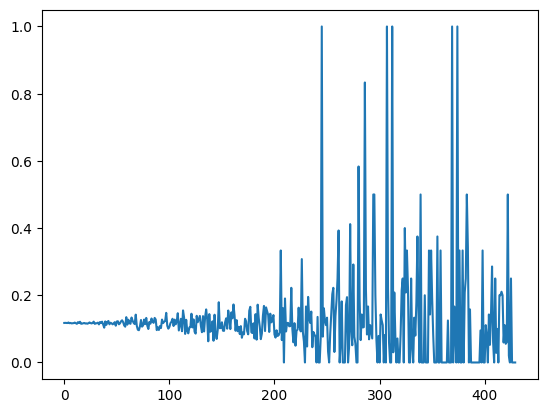

In [145]:
k["is_applied"].plot()

In [139]:
k

,num_not_approve,is_applied
0,0,0.117521
1,1,0.117106
2,2,0.113139
3,3,0.119018
4,4,0.118729
...,...,...
110,235,0.000000
111,240,0.166667
112,256,0.333333
113,280,0.500000


In [128]:
full_data["num_not_approve"]

0          5
1          5
2          0
3          0
4          0
          ..
4768893    0
4768894    0
4768895    0
4768896    0
4768897    0
Name: num_not_approve, Length: 4768898, dtype: int64

In [127]:
full_data["purpose"].value_counts()

생활비       2798900
대환대출      1363745
사업자금       188142
기타         138926
전월세보증금      97365
투자          89945
주택구입        72114
자동차구입       19761
Name: purpose, dtype: int64

In [89]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4768898 entries, 0 to 4768897
Data columns (total 30 columns):
 #   Column                            Dtype   
---  ------                            -----   
 0   application_id                    int64   
 1   bank_id                           int64   
 2   product_id                        int64   
 3   loan_limit                        int64   
 4   loan_rate                         float64 
 5   is_applied                        float64 
 6   user_id                           int64   
 7   birth_year                        int64   
 8   gender                            int64   
 9   credit_score                      int64   
 10  yearly_income                     int64   
 11  income_type                       int64   
 12  company_enter_month               int64   
 13  employment_type                   int64   
 14  houseown_type                     int64   
 15  desired_amount                    int64   
 16  purpose           